<a href="https://colab.research.google.com/github/Theekshana-se/Air-QualityPredict-DeepLearningProject/blob/LSTM_model/IT22207036_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Air Quality Prediction with LSTM

This notebook prepares, trains, and evaluates an LSTM model on `data.csv` to predict next-step air quality.

# 0) Setup: configurable knobs

In [3]:
# =========================
# CONFIG (edit as needed)
# =========================
CSV_PATH     = "/content/data/data.csv"   # path to your uploaded data
TARGET_COL   = "rspm"                  # default target (PM10); change to 'no2' or 'so2' if you want
LOCATION_COL = "location"              # grouping column for a city/station
DATE_COL     = "date"                  # will fall back to 'sampling_date' if needed
LOOKBACK     = 30                      # how many past days to feed the LSTM
HORIZON      = 1                       # predict next-day value
TEST_FRACTION= 0.15                    # final test split
VAL_FRACTION = 0.15                    # validation split (from the remaining training set)
RANDOM_SEED  = 42


# Data & variables (source, target)

In [5]:
# Topic: Loading & Exploring the Dataset
import pandas as pd
import numpy as np

# Robust CSV read
try:
    df = pd.read_csv(CSV_PATH, encoding="utf-8")
except UnicodeDecodeError:
    df = pd.read_csv(CSV_PATH, encoding="latin1")

print("Shape:", df.shape)
print("Columns:", list(df.columns))
df.head(10)


/tmp/ipython-input-1070418001.py:9: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CSV_PATH, encoding="latin1")


Shape: (435742, 13)
Columns: ['stn_code', 'sampling_date', 'state', 'location', 'agency', 'type', 'so2', 'no2', 'rspm', 'spm', 'location_monitoring_station', 'pm2_5', 'date']


,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01
5,152.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.4,25.7,NaN,NaN,NaN,NaN,1990-03-01
6,150.0,April - M041990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",5.4,17.1,NaN,NaN,NaN,NaN,1990-04-01
7,151.0,April - M041990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,8.7,NaN,NaN,NaN,NaN,1990-04-01
8,152.0,April - M041990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.2,23.0,NaN,NaN,NaN,NaN,1990-04-01
9,151.0,May - M051990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.0,8.9,NaN,NaN,NaN,NaN,1990-05-01


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435742 entries, 0 to 435741
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   stn_code                     291665 non-null  object 
 1   sampling_date                435739 non-null  object 
 2   state                        435742 non-null  object 
 3   location                     435739 non-null  object 
 4   agency                       286261 non-null  object 
 5   type                         430349 non-null  object 
 6   so2                          401096 non-null  float64
 7   no2                          419509 non-null  float64
 8   rspm                         395520 non-null  float64
 9   spm                          198355 non-null  float64
 10  location_monitoring_station  408251 non-null  object 
 11  pm2_5                        9314 non-null    float64
 12  date                         435735 non-null  object 
dtyp

# Loading & cleaning (dates, NaN handling)

In [7]:
# Drop columns we don't need
df = df.drop(['stn_code', 'agency', 'location_monitoring_station', 'pm2_5', 'date'], axis=1)

# Convert sampling_date to datetime
df['sampling_date'] = pd.to_datetime(df['sampling_date'], errors='coerce')

# Drop rows without date or location
df = df.dropna(subset=['sampling_date', 'location'])

# Sort data by date for consistency
df = df.sort_values(['state', 'location', 'sampling_date'])

print(df.info())

/tmp/ipython-input-2876289662.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['sampling_date'] = pd.to_datetime(df['sampling_date'], errors='coerce')


<class 'pandas.core.frame.DataFrame'>
Index: 412695 entries, 17206 to 435738
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   sampling_date  412695 non-null  datetime64[ns]
 1   state          412695 non-null  object        
 2   location       412695 non-null  object        
 3   type           412451 non-null  object        
 4   so2            379563 non-null  float64       
 5   no2            397520 non-null  float64       
 6   rspm           395516 non-null  float64       
 7   spm            178102 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 28.3+ MB
None


In [8]:
import matplotlib.pyplot as plt

# Count rows per city/location
city_counts = df['location'].value_counts().reset_index()
city_counts.columns = ['City', 'RecordCount']

print(city_counts.head(10))

            City  RecordCount
0       Guwahati         9739
1      Hyderabad         8928
2     Chandigarh         8227
3        Kolkata         7733
4          Delhi         7279
5          Kochi         7263
6         Jaipur         7257
7  Visakhapatnam         7108
8           Agra         7006
9         Nagpur         6970


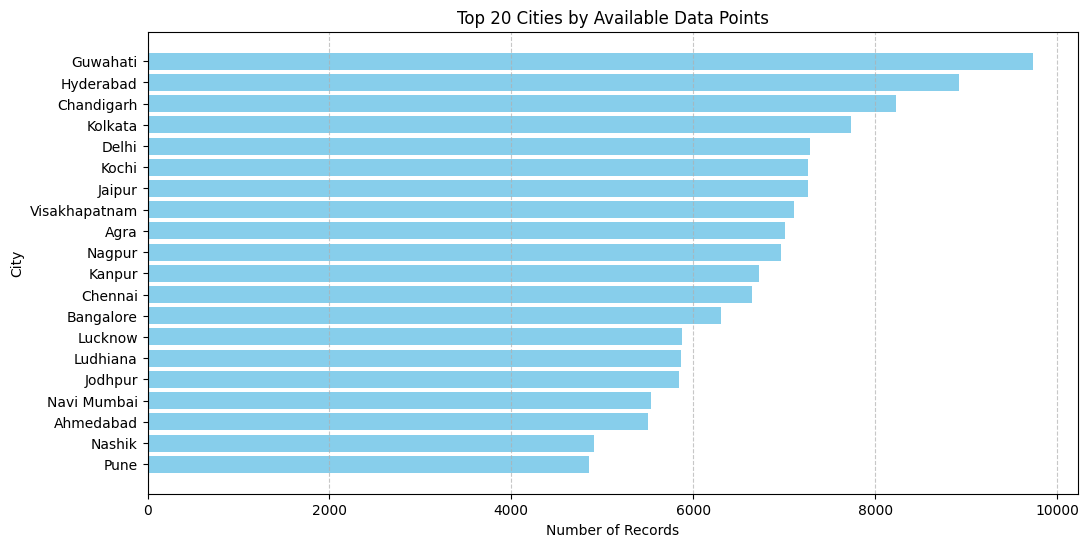

In [9]:
plt.figure(figsize=(12,6))
plt.barh(city_counts['City'].head(20), city_counts['RecordCount'].head(20), color='skyblue')
plt.xlabel('Number of Records')
plt.ylabel('City')
plt.title('Top 20 Cities by Available Data Points')
plt.gca().invert_yaxis()  # Largest bar at top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Data Preprocessing

In [10]:
# Topic: Data Preprocessing (dates, duplicates, target availability, selection of a single location)

# Ensure a usable date column
if DATE_COL not in df.columns:
    # fallback to sampling_date if present
    if "sampling_date" in df.columns:
        df["sampling_date"] = pd.to_datetime(df["sampling_date"], errors="coerce", dayfirst=True)
        df["date"] = df["sampling_date"]
        DATE_COL = "date"
    else:
        raise ValueError("No usable date column found (expected 'date' or 'sampling_date').")

# Coerce date column
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df = df.dropna(subset=[DATE_COL]).copy()

# Keep key columns
candidate_cols = ["stn_code","state","location","agency","type","so2","no2","rspm","spm","location_monitoring_station","pm2_5", DATE_COL]
present_cols   = [c for c in candidate_cols if c in df.columns]
df = df[present_cols].copy()

# Remove exact duplicates
df = df.drop_duplicates()

# Choose a single location with the most available TARGET_COL values
if LOCATION_COL not in df.columns:
    raise ValueError(f"'{LOCATION_COL}' column not found in data.")

if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found. Available: {list(df.columns)}")

loc_counts = (
    df.dropna(subset=[TARGET_COL])
      .groupby(LOCATION_COL)[TARGET_COL]
      .count()
      .sort_values(ascending=False)
)

if loc_counts.empty:
    raise ValueError(f"No non-null values for target '{TARGET_COL}'. Consider switching TARGET_COL.")

TOP_LOCATION = loc_counts.index[0]
print("Selected location with most target data:", TOP_LOCATION)

# Filter to this location and sort by time
dfl = df[df[LOCATION_COL] == TOP_LOCATION].copy()
dfl = dfl.sort_values(DATE_COL)

# Forward-fill and interpolate numeric columns
num_cols = dfl.select_dtypes(include=[np.number]).columns.tolist()
for c in num_cols:
    dfl[c] = dfl[c].ffill().bfill().interpolate(limit_direction="both")

# Keep a tidy, numeric feature table
# Include time-derived features
dfl["year"]  = dfl[DATE_COL].dt.year
dfl["month"] = dfl[DATE_COL].dt.month
dfl["day"]   = dfl[DATE_COL].dt.day

# Final feature set (exclude known identifiers)
drop_like = {LOCATION_COL, "stn_code", "agency", "type", "location_monitoring_station"}
feature_cols = [c for c in dfl.columns if c not in drop_like and c != DATE_COL]

# Ensure target still present and has variance
assert TARGET_COL in feature_cols, "Target missing from feature set after cleaning."
if dfl[TARGET_COL].nunique() < 2:
    raise ValueError("Target has insufficient variance after cleaning.")

print("Final columns used:", feature_cols)
dfl.head(10)


Selected location with most target data: Guwahati
Final columns used: ['state', 'so2', 'no2', 'rspm', 'spm', 'year', 'month', 'day']


,state,location,type,so2,no2,rspm,spm,date,year,month,day
26703,Assam,Guwahati,"Residential, Rural and other Areas",2.0,16.2,173.0,175.0,2004-01-02,2004,1,2
26781,Assam,Guwahati,"Residential, Rural and other Areas",3.8,25.5,220.0,175.0,2004-01-05,2004,1,5
26704,Assam,Guwahati,"Residential, Rural and other Areas",2.7,19.5,175.0,175.0,2004-01-06,2004,1,6
26782,Assam,Guwahati,"Residential, Rural and other Areas",3.5,27.3,233.0,175.0,2004-01-07,2004,1,7
26705,Assam,Guwahati,"Residential, Rural and other Areas",2.3,16.7,179.0,175.0,2004-01-08,2004,1,8
26706,Assam,Guwahati,"Residential, Rural and other Areas",2.0,19.2,180.0,175.0,2004-01-12,2004,1,12
26783,Assam,Guwahati,"Residential, Rural and other Areas",2.8,23.7,209.0,175.0,2004-01-13,2004,1,13
26707,Assam,Guwahati,"Residential, Rural and other Areas",2.3,17.8,166.0,175.0,2004-01-20,2004,1,20
26784,Assam,Guwahati,"Residential, Rural and other Areas",3.5,25.5,250.0,175.0,2004-01-21,2004,1,21
26708,Assam,Guwahati,"Residential, Rural and other Areas",2.7,20.7,188.0,175.0,2004-01-28,2004,1,28


# Train/Test Split and Scaling

In [11]:
# Topic: Train/Test Split and Scaling
from sklearn.preprocessing import MinMaxScaler

# Keep only rows with non-null target
dfl = dfl.dropna(subset=[TARGET_COL]).copy()

# Keep only numeric features for LSTM
dfl_num = dfl[feature_cols].select_dtypes(include=[np.number]).copy()

# Fit scalers
scaler_all   = MinMaxScaler()
scaler_target= MinMaxScaler()

all_scaled   = scaler_all.fit_transform(dfl_num)
target_scaled= scaler_target.fit_transform(dfl_num[[TARGET_COL]])

# Helper to create sequences
def make_sequences(X, y, lookback=30, horizon=1):
    Xs, ys = [], []
    for i in range(lookback, len(X)-horizon+1):
        Xs.append(X[i-lookback:i])
        ys.append(y[i+horizon-1])  # next-step target
    return np.array(Xs), np.array(ys)

# Time-based split indices
N = len(all_scaled)
test_size = int(np.floor(TEST_FRACTION * N))
trainval_end = N - test_size

X_all, y_all = make_sequences(all_scaled, target_scaled, lookback=LOOKBACK, horizon=HORIZON)

# Align with split after sequence creation
split_point = trainval_end - LOOKBACK - HORIZON + 1
X_trainval, y_trainval = X_all[:split_point], y_all[:split_point]
X_test,     y_test     = X_all[split_point:], y_all[split_point:]

# Validation from trainval
val_size = int(np.floor(VAL_FRACTION * len(X_trainval)))
X_train, X_val = X_trainval[:-val_size], X_trainval[-val_size:]
y_train, y_val = y_trainval[:-val_size], y_trainval[-val_size:]

X_train.shape, X_val.shape, X_test.shape


((6997, 30, 7), (1234, 30, 7), (1457, 30, 7))

# Model Architecture (LSTM)

In [12]:
# Topic: Model Architecture (LSTM)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.random.set_seed(RANDOM_SEED)

n_features = X_train.shape[-1]

model = keras.Sequential([
    layers.Input(shape=(LOOKBACK, n_features)),
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(32),
    layers.Dropout(0.2),
    layers.Dense(16, activation="relu"),
    layers.Dense(1)  # regression output
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[keras.metrics.MeanAbsoluteError(name="mae")]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,393 (122.63 KB)

 Trainable params: 31,393 (122.63 KB)

 Non-trainable params: 0 (0.00 B)

# Training the Model

In [13]:
# Topic: Training the Model
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - loss: 0.0098 - mae: 0.0753 - val_loss: 0.0053 - val_mae: 0.0545 - learning_rate: 0.0010
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0046 - mae: 0.0504 - val_loss: 0.0041 - val_mae: 0.0437 - learning_rate: 0.0010
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0038 - mae: 0.0438 - val_loss: 0.0035 - val_mae: 0.0402 - learning_rate: 0.0010
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.0034 - mae: 0.0408 - val_loss: 0.0035 - val_mae: 0.0402 - learning_rate: 0.0010
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.0034 - mae: 0.0408 - val_loss: 0.0035 - val_mae: 0.0402 - learning_rate: 0.0010
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 0.0033 - mae: 0.0401 - val_loss: 0.0034 - val_mae: 0.0403 - learning_rate: 0.0010
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.0032 - mae: 0.0396 - val_loss: 0.0037 - val_mae: 0.0410 - learning_rate: 0.0010
Epo

# Model Evaluation (MAE, RMSE, R2) with inverse scaling

In [14]:
# Topic: Model Evaluation (MAE, RMSE, R2) with inverse scaling
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict
y_val_pred  = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Inverse scale
def inv(x):
    return scaler_target.inverse_transform(x)

y_val_true_inv  = inv(y_val)
y_val_pred_inv  = inv(y_val_pred)
y_test_true_inv = inv(y_test)
y_test_pred_inv = inv(y_test_pred)

def metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    return mae, rmse, r2

val_mae,  val_rmse,  val_r2  = metrics(y_val_true_inv,  y_val_pred_inv)
test_mae, test_rmse, test_r2 = metrics(y_test_true_inv, y_test_pred_inv)

print("Validation  -> MAE: %.3f | RMSE: %.3f | R2: %.3f" % (val_mae, val_rmse, val_r2))
print("Test        -> MAE: %.3f | RMSE: %.3f | R2: %.3f" % (test_mae, test_rmse, test_r2))

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Validation  -> MAE: 31.183 | RMSE: 45.110 | R2: 0.621
Test        -> MAE: 23.426 | RMSE: 35.632 | R2: 0.399


# Data Visualizations (Matplotlib only, no seaborn)

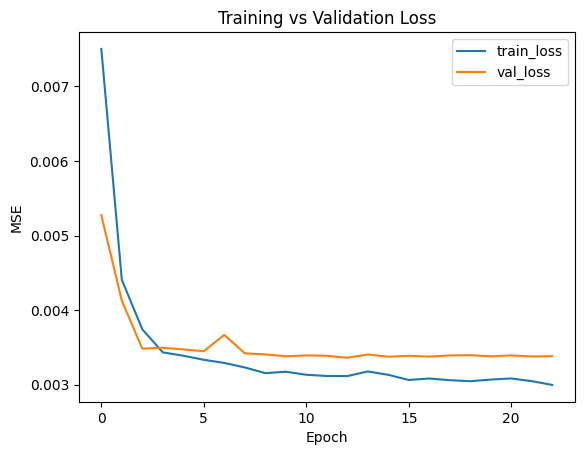

In [15]:
# Topic: Data Visualizations (Matplotlib only, no seaborn)

import matplotlib.pyplot as plt

# 7.1: Loss curves
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

# Actual vs Predicted (Test)

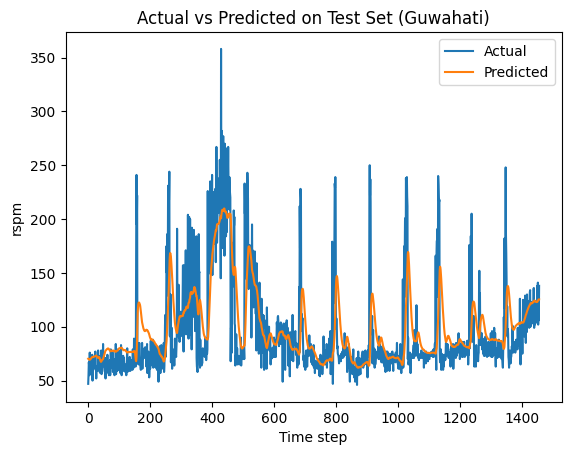

In [16]:
# 7.2: Actual vs Predicted (Test)
plt.figure()
plt.plot(y_test_true_inv, label="Actual")
plt.plot(y_test_pred_inv, label="Predicted")
plt.xlabel("Time step")
plt.ylabel(TARGET_COL)
plt.title(f"Actual vs Predicted on Test Set ({TOP_LOCATION})")
plt.legend()
plt.show()


# Residuals (Test)

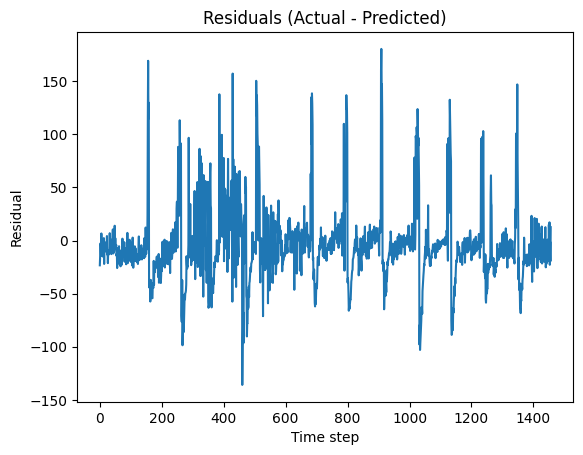

In [17]:
# 7.3: Residuals (Test)
residuals = (y_test_true_inv - y_test_pred_inv).ravel()
plt.figure()
plt.plot(residuals)
plt.xlabel("Time step")
plt.ylabel("Residual")
plt.title("Residuals (Actual - Predicted)")
plt.show()


# Correlation heatmap

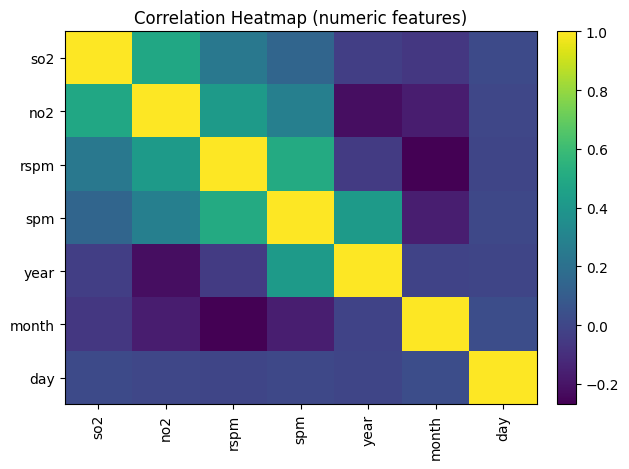

In [18]:
# 7.4: Correlation heatmap of numeric features (current location)
# Build correlation matrix
corr_df = dfl_num.corr()

plt.figure()
im = plt.imshow(corr_df.values, aspect="auto")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr_df.columns)), corr_df.columns, rotation=90)
plt.yticks(range(len(corr_df.columns)), corr_df.columns)
plt.title("Correlation Heatmap (numeric features)")
plt.tight_layout()
plt.show()

# Monthly bar plot (average target per month)

/tmp/ipython-input-3457500311.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = dfl.set_index(DATE_COL).resample("M")[TARGET_COL].mean()


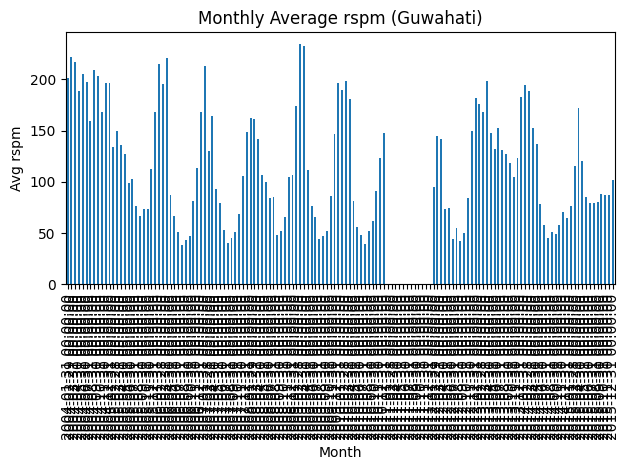

In [19]:
# 7.5: Monthly bar plot (average target per month)
monthly = dfl.set_index(DATE_COL).resample("M")[TARGET_COL].mean()

plt.figure()
monthly.plot(kind="bar")
plt.xlabel("Month")
plt.ylabel(f"Avg {TARGET_COL}")
plt.title(f"Monthly Average {TARGET_COL} ({TOP_LOCATION})")
plt.tight_layout()
plt.show()

# Scatter plot

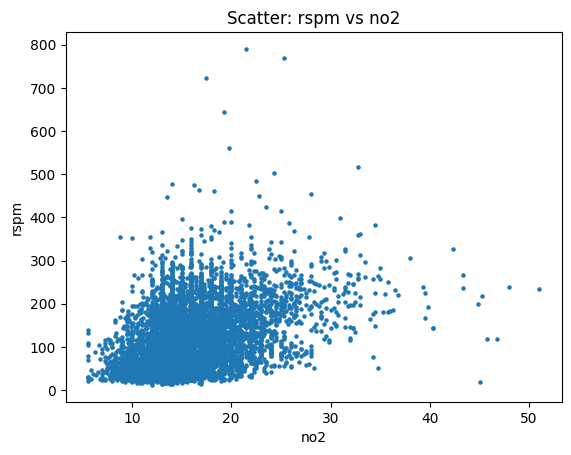

In [20]:
# 7.6: Scatter plot: target vs a related pollutant if present
candidate_x = None
for c in ["no2", "so2", "spm", "pm2_5"]:
    if c in dfl_num.columns and c != TARGET_COL:
        candidate_x = c
        break

if candidate_x is not None:
    plt.figure()
    plt.scatter(dfl_num[candidate_x], dfl_num[TARGET_COL], s=5)
    plt.xlabel(candidate_x)
    plt.ylabel(TARGET_COL)
    plt.title(f"Scatter: {TARGET_COL} vs {candidate_x}")
    plt.show()
else:
    print("No suitable secondary pollutant found for scatter plot.")


# Making Predictions (rolling next-day forecasts)

In [21]:
# Topic: Making Predictions (rolling next-day forecasts)
k = 7  # predict next 7 days one by one
last_window = all_scaled[-LOOKBACK:].copy()

future_preds = []
window = last_window.copy()

for _ in range(k):
    x_in = window.reshape(1, LOOKBACK, -1)
    yhat_scaled = model.predict(x_in)
    yhat = scaler_target.inverse_transform(yhat_scaled)[0,0]
    future_preds.append(yhat)
    # naive update: append the predicted target into the last feature vector only for the target position
    # find target index
    t_idx = list(dfl_num.columns).index(TARGET_COL)
    next_row = window[-1].copy()
    next_row[t_idx] = yhat_scaled[0,0]
    window = np.vstack([window[1:], next_row])

print("Next-day predictions:", future_preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Next-day predictions: [np.float32(125.68989), np.float32(125.91243), np.float32(126.21205), np.float32(126.479126), np.float32(126.72462), np.float32(126.95029), np.float32(127.21029)]


In [22]:
k = 7  # number of future days
window = all_scaled[-LOOKBACK:].copy()

# figure out the last known date from your filtered frame
last_date = pd.to_datetime(dfl[DATE_COL].max())
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=k, freq="D")

future_preds = []
t_idx = list(dfl_num.columns).index(TARGET_COL)  # where the target sits among features

for _ in range(k):
    x_in = window.reshape(1, LOOKBACK, -1)
    yhat_scaled = model.predict(x_in)
    yhat = scaler_target.inverse_transform(yhat_scaled)[0, 0]
    future_preds.append(yhat)

    # update the rolling window by inserting the predicted target for the next step
    next_row = window[-1].copy()
    next_row[t_idx] = yhat_scaled[0, 0]  # keep everything else as last known
    window = np.vstack([window[1:], next_row])

# neat table
future_df = pd.DataFrame({
    "date": future_dates,
    f"pred_{TARGET_COL}": np.array(future_preds, dtype=float)
})
print(future_df.to_string(index=False))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
      date  pred_rspm
2016-01-01 125.689888
2016-01-02 125.912430
2016-01-03 126.212051
2016-01-04 126.479126
2016-01-05 126.724617
2016-01-06 126.950287
2016-01-07 127.210289


# Forecasts (next-day & 7-day) + short conclusion

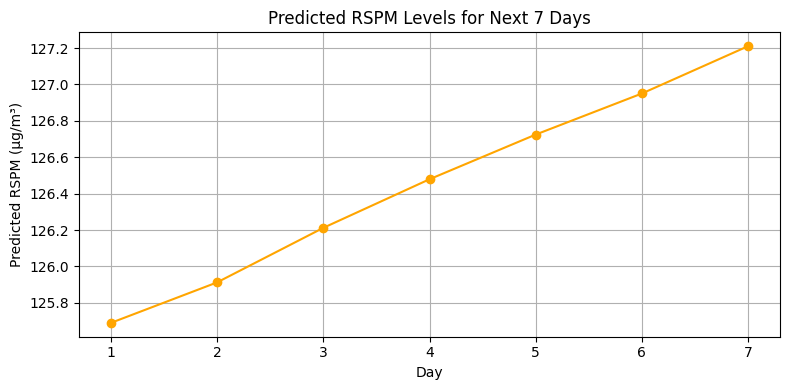

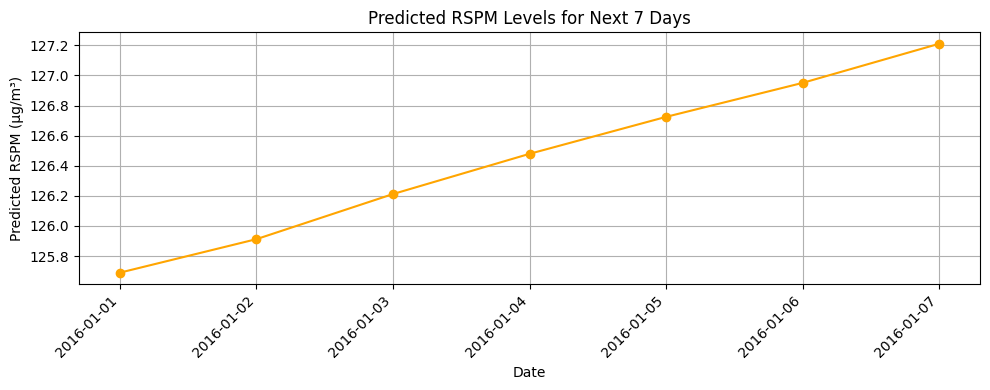

In [23]:
# If you followed the earlier block, future_df has columns: ["date", f"pred_{TARGET_COL}"]
# Make sure we have the predictions as a plain array
future_predictions_real = future_df[f"pred_{TARGET_COL}"].to_numpy()
k = len(future_predictions_real)

# 1) Plot with day index 1..k (exactly like your example)
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(range(1, k+1), future_predictions_real, marker='o', color='orange')
plt.title(f'Predicted {TARGET_COL.upper()} Levels for Next {k} Days')
plt.xlabel('Day')
plt.ylabel(f'Predicted {TARGET_COL.upper()} (µg/m³)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2) Optional: plot with actual calendar dates on the x-axis
plt.figure(figsize=(10,4))
plt.plot(future_df["date"], future_predictions_real, marker='o', color='orange')
plt.title(f'Predicted {TARGET_COL.upper()} Levels for Next {k} Days')
plt.xlabel('Date')
plt.ylabel(f'Predicted {TARGET_COL.upper()} (µg/m³)')
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Quick accuracy metrics

Test MAE = 23.43  |  RMSE = 35.63  |  R² = 0.399


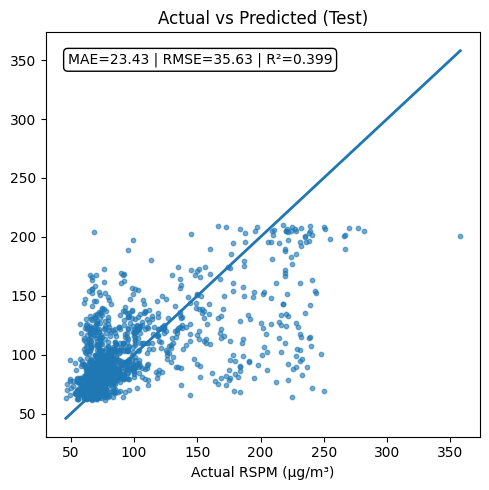

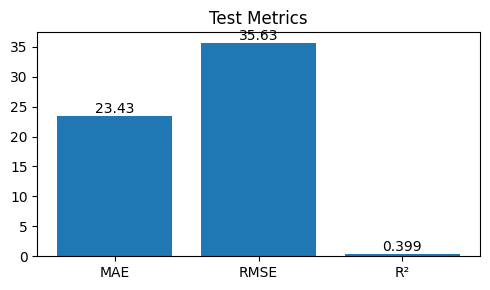

In [26]:
# Quick accuracy metrics + two concise visuals (parity + metrics bar)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ensure arrays are 1D
y_true = np.asarray(y_test_true_inv).ravel()
y_pred = np.asarray(y_test_pred_inv).ravel()

mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2   = r2_score(y_true, y_pred)

print(f"Test MAE = {mae:.2f}  |  RMSE = {rmse:.2f}  |  R² = {r2:.3f}")

# 1) Parity plot (ideal = y = x)
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, s=10, alpha=0.6)
min_v = float(min(y_true.min(), y_pred.min()))
max_v = float(max(y_true.max(), y_pred.max()))
plt.plot([min_v, max_v], [min_v, max_v], linewidth=2)  # y = x
plt.xlabel(f"Actual {TARGET_COL.upper()} (µg/m³)")
txt = f"MAE={mae:.2f} | RMSE={rmse:.2f} | R²={r2:.3f}"
plt.gca().text(0.05, 0.95, txt, transform=plt.gca().transAxes,
               va="top", ha="left", bbox=dict(boxstyle="round", fc="white"))
plt.title("Actual vs Predicted (Test)")
plt.tight_layout()
plt.show()

# 2) Tiny metrics bar (quick glance)
plt.figure(figsize=(5,3))
vals = [mae, rmse, r2]
labels = ["MAE", "RMSE", "R²"]
plt.bar(labels, vals)
for i, v in enumerate(vals):
    plt.text(i, v, f"{v:.2f}" if i < 2 else f"{v:.3f}", ha="center", va="bottom")
plt.title("Test Metrics")
plt.tight_layout()
plt.show()


In [28]:
report_notes = f"""
Problem: Next-day air quality regression on Indian monitoring data.
Target: {TARGET_COL} (per-station time series). Location used: {TOP_LOCATION}.
Preprocessing: date parsing, sorting, forward-fill + interpolation, numeric-only features, MinMax scaling.
Model: Two-layer LSTM with dropout, dense head (regression).
Training: EarlyStopping + ReduceLROnPlateau; splits are time-based (train/val/test).
Metrics: MAE, RMSE, R^2 on validation and test. Plots include loss curves, actual vs predicted, residuals.
Visualizations: correlation heatmap; monthly average of target; scatter of target vs another pollutant.
Reproducibility: All random seeds set where applicable.
"""
print(report_notes)


Problem: Next-day air quality regression on Indian monitoring data.
Target: rspm (per-station time series). Location used: Guwahati.
Preprocessing: date parsing, sorting, forward-fill + interpolation, numeric-only features, MinMax scaling.
Model: Two-layer LSTM with dropout, dense head (regression).
Training: EarlyStopping + ReduceLROnPlateau; splits are time-based (train/val/test).
Metrics: MAE, RMSE, R^2 on validation and test. Plots include loss curves, actual vs predicted, residuals.
Visualizations: correlation heatmap; monthly average of target; scatter of target vs another pollutant.
Reproducibility: All random seeds set where applicable.

